### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBacken.figure_format = 'retina'
import seaborn as sns
import statsmodels.api as sm

### Importing cleaned dataset

In [2]:
# Importing cleaned dataset and dropping old index

retail = pd.read_csv('./dataset/retail.csv')
retail = retail.drop('Unnamed: 0', axis=1)
retail.head()

,Branch,YearMonth,Weekday,Hour,Product line,Unit price,Quantity,Total,Rating
0,A,2019-01,5,13,Health and beauty,74.69,7,548.9715,9.1
1,C,2019-03,4,10,Electronic accessories,15.28,5,80.2200,9.6
2,A,2019-03,6,13,Home and lifestyle,46.33,7,340.5255,7.4
3,A,2019-01,6,20,Health and beauty,58.22,8,489.0480,8.4
4,A,2019-02,4,10,Sports and travel,86.31,7,634.3785,5.3


### First insights

In [3]:
retail.describe()

,Weekday,Hour,Unit price,Quantity,Total,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,991.000000,1000.00000
mean,3.032000,14.910000,55.672130,5.510000,316.604752,6.97270
std,1.973543,3.186857,26.494628,2.923431,237.709589,1.71858
min,0.000000,10.000000,10.080000,1.000000,10.678500,4.00000
25%,1.000000,12.000000,32.875000,3.000000,122.167500,5.50000
50%,3.000000,15.000000,55.230000,5.000000,252.756000,7.00000
75%,5.000000,18.000000,77.935000,8.000000,464.667000,8.50000
max,6.000000,20.000000,99.960000,10.000000,951.825000,10.00000


- The mean is most of the time closed to the median which shows that the data is concentrated around the mean.
- Unit price (in USD): between 10.08 to 99.96 with an average of 55.67
- Quantity: between 1 and 10 with a median of 5 - the buyers don't buy many articles at once
- Total spent (in USD): between 10ish to 951.82 with an average around 316
- Ratings: between 4 and 10 with a mean of 6.97

In [4]:
retail.columns

Index(['Branch', 'YearMonth', 'Weekday', 'Hour', 'Product line', 'Unit price',
       'Quantity', 'Total', 'Rating'],
      dtype='object')

### 1. Can we see different customer behavior depending on the branches?

#### Branches distribution

In [5]:
# Branches distribution
retail['Branch'].value_counts()

A    340
B    332
C    328
Name: Branch, dtype: int64

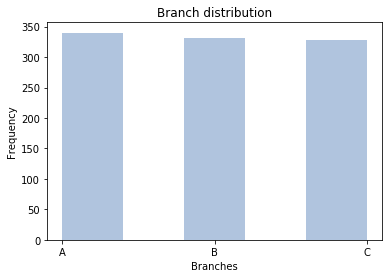

In [6]:
# Very close to balanced population
plt.hist(retail["Branch"].sort_values(), color = "lightsteelblue", bins = 5)
plt.xlabel('Branches')
plt.ylabel('Frequency')
plt.title('Branch distribution')
plt.show()

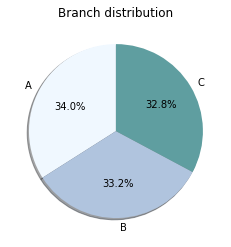

In [7]:
plt.pie(retail['Branch'].value_counts(), labels = ['A','B', 'C'], 
        colors = ['aliceblue', 'lightsteelblue', 'cadetblue'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Branch distribution')
plt.show()

#### Product line

In [8]:
# Branches distribution by branches (in %)
branch_cross = pd.crosstab(index = retail['Branch'], columns = retail['Product line'], normalize='index')\
    .round(4)*100
branch_cross

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
Branch,,,,,,
A,17.65,15.00,17.06,13.82,19.12,17.35
B,16.57,18.67,15.06,15.96,15.06,18.67
C,16.77,19.82,20.12,15.85,13.72,13.72


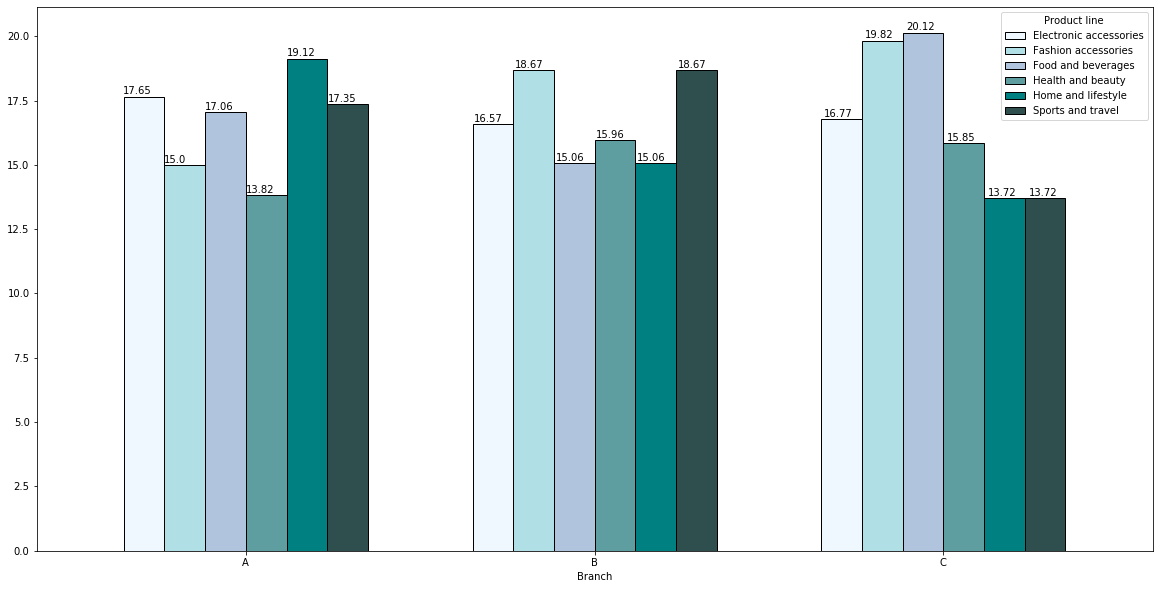

In [9]:
ax = branch_cross.plot.bar(color = ['aliceblue', 'powderblue', 'lightsteelblue', 'cadetblue', 'teal', 
                                    'darkslategrey'], edgecolor= 'black', figsize=(20,10), width = 0.7)
plt.xticks(rotation = 360)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

All the branches sales are different:

Branch A: 
- 19.12% of the sales are 'Home and lifestyle' products
- Only 13.82% of the sales are 'Health and beauty' products

Branch B:
- 'Fashion accessories' and 'Sports and travel' are the most sale products with 18.67 of the total for each 
- Least sale: 'Food and beverage' and 'Home and lifestyle'

Branch C:
- Branch with the most difference between the products
- Most sold: 'Fashion accessories' and 'Food and beverage' with 19.82% and 20.12%
- Least sold: 'Home and lifestyle' and 'Sports and travel' with 13.72%

#### Quantity

In [10]:
quantity = pd.crosstab(index = retail.Branch, columns = retail.Quantity)

### 2. Is the time influencing the customer behavior?

In [11]:
# Hour pivot table (mean)
hour_pivot = pd.pivot_table(index = 'Hour', values = ['Quantity', 'Rating', 'Total'], 
                            data = retail, aggfunc = 'mean')
hour_pivot

,Quantity,Rating,Total
Hour,,,
10,5.198020,7.098020,311.103772
11,5.700000,6.806667,337.525883
12,5.629213,7.300000,292.875084
13,5.679612,7.030097,309.842697
14,5.963855,6.934940,363.240841
15,5.196078,6.876471,305.681456
16,5.454545,6.859740,308.843780
17,5.608108,6.939189,320.859288
18,5.107527,7.187097,279.896129


In [12]:
# Weekday pivot table (mean)
day_pivot = pd.pivot_table(index = 'Weekday', values = ['Quantity', 'Rating', 'Total'], 
                           data = retail, aggfunc = 'mean')
day_pivot

,Quantity,Rating,Total
Weekday,,,
0,5.104000,7.153600,303.192624
1,5.455696,7.003165,321.400385
2,5.594406,6.805594,290.649750
3,5.471014,6.889855,328.617739
4,5.453237,7.076259,300.174232
5,5.603659,6.901829,333.793639
6,5.849624,7.011278,334.269868


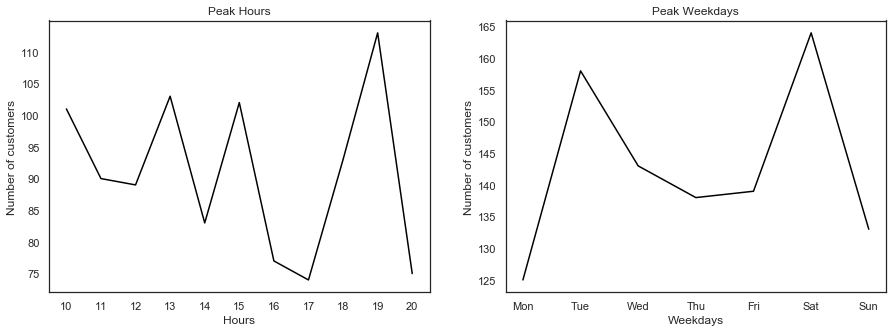

In [35]:
# Defining peak hours
sns.set(style="white", palette="GnBu_d")

f, axs = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

hour = retail['Hour'].value_counts().sort_index()
day = retail['Weekday'].value_counts().sort_index()

sns.lineplot(data = hour, ax=axs[0], color = "k")
axs[0].set_xticks(np.arange(10, 21))
axs[0].set_xlabel('Hours')
axs[0].set_ylabel('Number of customers')
axs[0].set_title('Peak Hours')

sns.lineplot(data = day, ax=axs[1], color = "k")
ticks = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axs[1].set_xticklabels(labels = ticks)
axs[1].set_xlabel('Weekdays')
axs[1].set_ylabel('Number of customers')
axs[1].set_title('Peak Weekdays')

plt.show()

- Peak hour: 19 (low hour: 17)
- Peak weekday: Tuesday and Saturday (low weekday: Monday & Sunday)

##### Product line

In [14]:
# Product sale VS Hour (in %)
product_hour = pd.crosstab(index = retail['Hour'], columns = retail['Product line'], normalize='columns')\
    .round(4)*100
product_hour

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
Hour,,,,,,
10,10.00,7.87,11.49,11.18,11.25,9.04
11,10.59,7.87,6.32,6.58,13.12,9.64
12,9.41,10.67,5.75,9.21,8.75,9.64
13,7.65,10.67,8.62,11.18,12.50,11.45
14,8.24,8.43,6.90,12.50,5.62,8.43
15,8.82,10.11,12.07,7.89,11.88,10.24
16,6.47,6.74,9.20,6.58,5.00,12.05
17,8.24,7.30,3.45,7.24,10.62,7.83
18,11.76,10.67,9.77,9.21,6.88,7.23


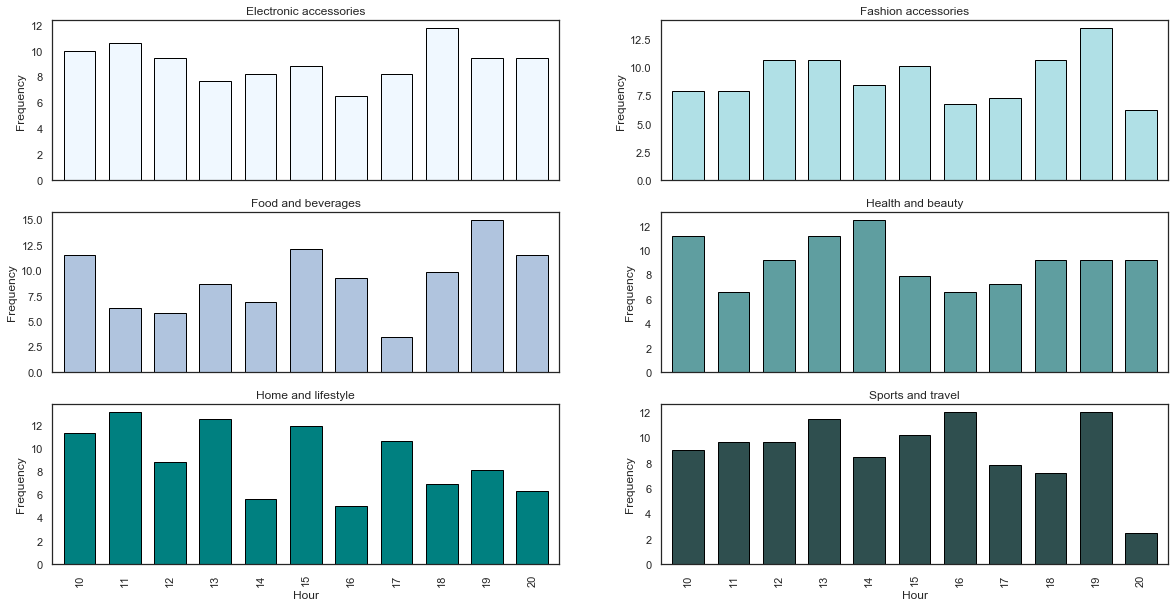

In [37]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (20, 25), sharex = True)

product_hour['Electronic accessories'].T.plot.bar(color = 'aliceblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[0, 0])
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Electronic accessories')

product_hour['Fashion accessories'].T.plot.bar(color = 'powderblue'
                           , edgecolor= 'black', figsize=(20,10), width = 0.7, ax=axs[0, 1])
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Fashion accessories')

product_hour['Food and beverages'].T.plot.bar(color = 'lightsteelblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 0])
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Food and beverages')

product_hour['Health and beauty'].T.plot.bar(color = 'cadetblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 1])
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Health and beauty')

product_hour['Home and lifestyle'].T.plot.bar(color = 'teal'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 0])
axs[2, 0].set_xlabel('Hour')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Home and lifestyle')

product_hour['Sports and travel'].T.plot.bar(color = 'darkslategrey'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 1])
axs[2, 1].set_xlabel('Hour')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('Sports and travel')

plt.show()

In [41]:
# Product sale VS weekday (in %)
product_day = pd.crosstab(index = retail['Weekday'], columns = retail['Product line'], normalize='columns')\
    .round(4)*100
product_day

Product line,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
Weekday,,,,,,
0,13.53,10.11,12.64,17.11,12.50,9.64
1,17.06,14.61,14.94,19.08,13.75,15.66
2,10.59,15.73,18.97,12.50,11.88,15.66
3,21.18,11.80,11.49,12.50,11.88,13.86
4,10.00,16.85,10.92,17.11,15.00,13.86
5,15.88,19.66,17.82,12.50,15.00,16.87
6,11.76,11.24,13.22,9.21,20.00,14.46


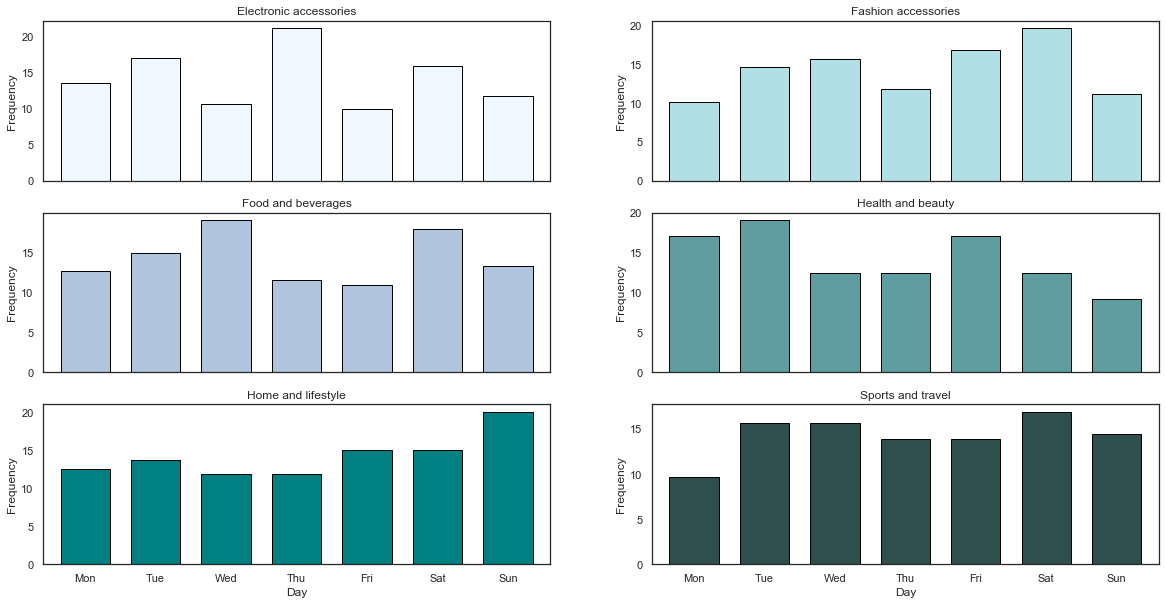

In [33]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (20, 25), sharex = True)

product_day['Electronic accessories'].T.plot.bar(color = 'aliceblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[0, 0])
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Electronic accessories')

product_day['Fashion accessories'].T.plot.bar(color = 'powderblue'
                           , edgecolor= 'black', figsize=(20,10), width = 0.7, ax=axs[0, 1])
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Fashion accessories')

product_day['Food and beverages'].T.plot.bar(color = 'lightsteelblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 0])
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Food and beverages')

product_day['Health and beauty'].T.plot.bar(color = 'cadetblue'
                           , edgecolor= 'black', width = 0.7, ax=axs[1, 1])
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Health and beauty')

product_day['Home and lifestyle'].T.plot.bar(color = 'teal'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 0])
axs[2, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],  rotation = 'horizontal')
axs[2, 0].set_xlabel('Day')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Home and lifestyle')

product_day['Sports and travel'].T.plot.bar(color = 'darkslategrey'
                           , edgecolor= 'black', width = 0.7, ax=axs[2, 1])
axs[2, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation = 'horizontal')
axs[2, 1].set_xlabel('Day')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('Sports and travel')

plt.show()

##### Quantity

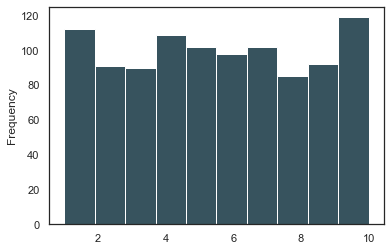

In [58]:
# Distribution
retail['Quantity'].plot(kind = 'hist', bins = 10)
plt.show()